Name: Kristian Gyene
Username: kristsgy

## IN3050/IN4050 Mandatory Assignment 2: Supervised Learning

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html (This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others.)
### Delivering

**Deadline**: Wednesday, March 25, 2020, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution. (If you have problems making a pdf at your own machine, you can make it at the IFI linux cluster.)

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.


### Goals of the exercise
This exercise has three parts. The goal of the first part is to get some more experience with supervised classification. We will use simple synthetic datasets and focus on the learning algorithms. 

The goal of the second part is to consider the implementaion of the  Multi-layer feed forward neural network, often called Multi-layer perceptron (MLP).

The third part, which is the smallest one, is dedicated to evaluation.

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

### Beware
This is a new assignment. There might occur typos or ambiguities. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your
own and explain them!

### Intialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the and of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [3]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]], 
                  n_features=2, random_state=2019)

In [4]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [5]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]

Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [6]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')

Plot the two training sets.

### NOTE
Plotting both (X,t) and (X, t2) using the same technique as in week 7. 

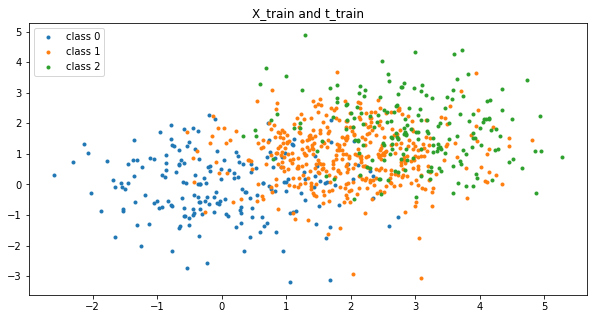

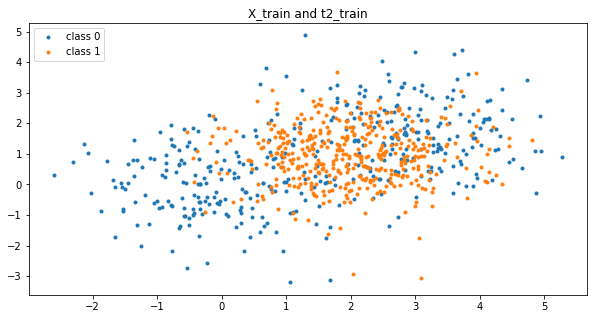

In [7]:
#X_train and t_train
plt.figure(figsize=(10,5))
labels = set(t_train)
for label in labels:
    plt.plot(X_train[t_train == label][:, 1], X_train[t_train == label][:, 0], 
    '.', label="class {}".format(label))
    plt.legend(loc='upper left')
    plt.title('X_train and t_train')
plt.show()

#X_train and t2_train
plt.figure(figsize=(10,5))
labels = set(t2_train)
for label in labels:
    plt.plot(X_train[t2_train == label][:, 1], X_train[t2_train == label][:, 0], 
    '.', label="class {}".format(label))
    plt.legend(loc='upper left')
    plt.title('X_train and t2_train')
plt.show()

## Binary classifiers

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may use the implementation from exercise set week07 or make your own. You should make one improvement. The implementation week07 runs for a set number of epochs. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

Train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. Choose what you think is optimal *diff*. Report accuracy and save it for later.

### NOTE
I used the implementation from week 7 and tweaked it a little. Now it is sending the diff value in the fit-method, and it updates as long as the diff is less than the update(with is the mse_before_update - mse_after_update). First, I set the diff to be 0.001, but later i found out i got better accuracy with diff to be 0.00001 The accuracy i got was 0.58.

In [42]:
class NumpyClassifier():
    """Common methods to all numpy classifiers --- if any"""
    
    def accuracy(self, X_test, y_test, **kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred == y_test) / len(pred)

In [195]:
def add_bias(X):
    sh = X.shape
    if len(sh) == 1:
        return np.concatenate([np.array([1]), X])
    else:
        m = sh[0]
        bias = np.ones((m, 1))
        return np.concatenate([bias, X], axis = 1)
    
def mse(y, y_pred):
    sum_errors = 0.
    for i in range(0,len(y)):
        sum_errors += (y[i] - y_pred[i])**2
    mean_squared_error = sum_errors/len(y)
    return mean_squared_error

In [196]:
class NumpyLinRegClass(NumpyClassifier):

    def fit(self, X_train, t_train, gamma=0.1, epochs=1, diff=0.00001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        update = 1
        
        while update > diff:
            error = mse(t_train, X_train @ theta)
            theta -= gamma / k *  X_train.T @ (X_train @ theta - t_train) 
            next_error = mse(t_train, X_train @ theta)
            update = error - next_error
            epochs+=1
        
        
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.theta
        return score > threshold

In [197]:
lin_cl = NumpyLinRegClass()
lin_cl.fit(X_train, t2_train)
accuracy_lin = lin_cl.accuracy(X_val, t2_val)
print("Linear regression accuracy:", accuracy_lin)

Linear regression accuracy: 0.58


### Logistic regression
Do the same for logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.

### NOTE
I did the same with logistic regresson, but found out i got the best accuray with diff = 0.001. Then i got the accuracy 0.60. For calculating error i used MSE, even though it might be even better with cross-entropy loss.

In [198]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def mse(y, y_pred):
    sum_errors = 0.
    for i in range(0,len(y)):
        sum_errors += (y[i] - y_pred[i])**2
    mean_squared_error = sum_errors/len(y)
    return mean_squared_error

In [199]:
class NumpyLogReg(NumpyClassifier):

    def fit(self, X_train, t_train, gamma=0.1, epochs=1, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        update = 1
        
        while update > diff:
            error = mse(t_train, X_train @ theta)
            theta -= gamma / k *  X_train.T @ (self.forward(X_train) - t_train)  
            next_error = mse(t_train, X_train @ theta)
            update = error - next_error
            epochs+=1
    
    def forward(self, X):
        return logistic(X @ self.theta)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score>threshold).astype('int')

In [200]:
lr_cl = NumpyLogReg()
lr_cl.fit(X_train, t2_train)
accuracy_log = lr_cl.accuracy(X_val, t2_val)
print("Logistic regression accuracy:", accuracy_log)

Logistic regression accuracy: 0.6


### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier. You may use the implementation from the week05 exercise set. Beware, though, that we represented the data differently from what we do here, using Python lists instead of numpy arrays. You therefore have to either modify the representation of the data or the code a little.

Train on (X_train, t2_train) and test on (X2_val, x2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.

### NOTE
I used the implementation from week 5. I chose to modify the representation of the data in order to make it fit to the classifier. The way I did it was that converted the numpy-arrays to lists. The accuracy I got for KNN is 0.77.

In [201]:
class PyClassifier():
    """Common methods to all python classifiers --- if any"""
    
    def accuracy(self,X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier 
        using the predict method"""
        predicted = [self.predict(a, **kwargs) for a in X_test]
        equal = len([(p, g) for (p,g) in zip(predicted, y_test) if p==g])
        return equal / len(y_test)

In [202]:
from collections import Counter

def distance_L2(a, b):
    "L2-distance using comprehension"
    s = sum((x - y) ** 2 for (x,y) in zip(a,b))
    return s ** 0.5

distance_L2((3,4,0),(0,0,12))

def majority(a):
    counts = Counter(a)
    return counts.most_common()[0][0]

class PykNNClassifier(PyClassifier):
    """kNN classifier using pure python representations"""
    
    def __init__(self, k=3, dist=distance_L2):
        self.k = k
        self.dist = dist
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, a):
        X = self.X_train
        y = self.y_train
        distances = [(self.dist(a, b), b, c) for (b, c) in zip(X, y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0: self.k]]
        return majority(predictors)

In [203]:
best_accuracy_knn = [0, 0]

for k in range(1, 20):
    cl = PykNNClassifier(k=k)
    cl.fit(X_train.tolist(), t2_train.tolist())
    if(cl.accuracy(X_val.tolist(), t2_val.tolist()) > best_accuracy_knn[1]):
        best_accuracy_knn[0] = k
        best_accuracy_knn[1] = cl.accuracy(X_val.tolist(), t2_val.tolist())
print("Best KNN accuracy =", str(best_accuracy_knn[1]) + ". With k =", str(best_accuracy_knn[0]) + ".")

Best KNN accuracy = 0.7675. With k = 14.


### Simple perceptron
Finally, run the simple perceptron (week05) on the same set, and report and store accuracy.

### NOTE
I used the implementation from week 5. I chose to modify the representation of the data the same way as in KNN to make it fit for the classifier. The accuracy I got for perceptron is 0.66.

In [204]:
class PyPerClassifier(PyClassifier):
    """Simple perceptron python classifier"""
    
    def fit(self, X_train, y_train, eta=1, epochs=1):
        """Train the self.weights on the training data eith learning
        rate eta, running epochs many epochs"""
        X_train = [[1]+list(x) for x in X_train]    
        self.dim = dim = len(X_train[0])
        self.weights = weights = [0 for _ in range(dim)]
        for e in range(epochs):
            for x, t in zip(X_train, y_train):
                y = int(self.forward(x)>0)
                for i in range(dim):
                    weights[i] += eta * (t - y) * x[i]
        
    def forward(self, x):
        """Calculate the score for the item x"""
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score       
    
    def predict(self, x):
        """Predict the value for the item x"""
        x = [1] + list(x)
        score = self.forward(x)
        return int(score > 0)

In [205]:
best_accuracy_per = [0, 0]

for i in range(1, 20):
    cl = PyPerClassifier()
    cl.fit(X_train.tolist(), t2_train.tolist(), eta = 0.1, epochs = i)
    if(cl.accuracy(X_val.tolist(), t2_val.tolist()) > best_accuracy_per[1]):
        best_accuracy_per[0] = i
        best_accuracy_per[1] = cl.accuracy(X_val.tolist(), t2_val.tolist())
print("Best perceptron accuracy =", str(best_accuracy_per[1]) + ". After epoch =", str(best_accuracy_per[0]) + ".")

Best perceptron accuracy = 0.6625. After epoch = 17.


### Summary
Report the accuracies for the four classifiers in a table.

Write a couple of sentences where you comment on what you see. Are the results as you expected?

### NOTE
Plotted all the accuracies in a table. They all got a accuracy in the range 0.5 to 0.8.

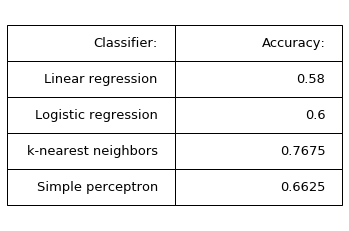

'\nLooks like the k-nearest neighbors got the best score. Its a little surprising because there is no\nclear line between the two classes when looking at the plotted data. They all got a accuracy around \n0.5-0.8, and I am surprised that they did not get higher scores. Linear regression is the\nleast accurate, and thats probably because the data is all spread out. However, its easy to see that this \ndata-set is not well suited for linear classifiers looking at the plot.\n'

In [54]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
accuracies = [["Classifier:", "Accuracy:"],
             ["Linear regression", accuracy_lin],
             ["Logistic regression", accuracy_log],
             ["k-nearest neighbors", best_accuracy_knn[1]],
             ["Simple perceptron", best_accuracy_per[1]]]
table = ax.table(cellText=accuracies, loc='center')
table.set_fontsize(16)
table.scale(1,3)
ax.axis('off')
plt.show()

Looks like the k-nearest neighbors got the best score. Its a little surprising because there is no
clear line between the two classes when looking at the plotted data. They all got a accuracy around 
0.5-0.8, and I am surprised that they did not get higher scores. Linear regression is the
least accurate, and thats probably because the data is all spread out. However, its easy to see that this 
data-set is not well suited for linear classifiers looking at the plot.

# Multi-class classifiers
We now turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier. Train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*. Choose the one you find best and report the accuracy.

### NOTE
I ran the KNN classifier with 3 classes instead of 2. The accuracy increased a little bit to 0.77.

In [55]:
best_multi_accuracy_knn = [0, 0]

for k in range(1, 20):
    cl = PykNNClassifier(k=k)
    cl.fit(X_train.tolist(), t_train.tolist())
    if(cl.accuracy(X_val.tolist(), t_val.tolist()) > best_multi_accuracy_knn[1]):
        best_multi_accuracy_knn[0] = k
        best_multi_accuracy_knn[1] = cl.accuracy(X_val.tolist(), t_val.tolist())
print("Best KNN accuracy =", str(best_multi_accuracy_knn[1]) + ". With k =", str(best_multi_accuracy_knn[0]) + ".")

Best KNN accuracy = 0.77. With k = 14.


### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

Extend the logisitc regression classifier to a multi-class classifier. To do this, you must modify the target values from scalars to arrays. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), and report the accuracy.

### NOTE
I trained one classifier for every three classes. I did not modify the target values, but i isolated every class(0 vs 1and2, 1 vs 0and2, 2 vs 0and1), and chose the class with the best accuracy. For this i got a accuracy of 0.81. Edit: I realise now that this is not the right way to do the one-vs-rest, but considering the lack of time I have had, I have not been able to change it.

In [56]:
class NumpyOvR(NumpyClassifier):

    def fit(self, X_train, t_train, gamma=0.1, epochs=1, diff=0.001):
        """X_train is a Nxm matrix, N data points, m features
        t_train are the targets values for training data"""
        
        (k, m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        update = 1
        
        while update > diff:
            error = mse(t_train, X_train @ theta)
            theta -= gamma / k *  X_train.T @ (self.forward(X_train) - t_train)  
            next_error = mse(t_train, X_train @ theta)
            update = error - next_error
            epochs+=1    
    
    def forward(self, X):
        return logistic(X @ self.theta)
    
    def score(self, x):
        z = add_bias(x)
        score = self.forward(z)
        return score
    
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = self.forward(z)
        return (score > threshold).astype('int')

In [57]:
accuracies = []
for i in range(3): #Train on three different classifiers
    OvR_cl = NumpyOvR()
    t_val_binary = (t_val == i).astype('int') #Isolating the class in val
    t_train_binary = (t_train == i).astype('int') #Isolating the class in train
    OvR_cl.fit(X_train, t_train_binary)
    multi_accuracy_log = OvR_cl.accuracy(X_val, t_val_binary)
    accuracies.append(multi_accuracy_log)

print("Logistic regression accuracy: {0:.2f}".format(max(accuracies)))

Logistic regression accuracy: 0.81


Discuss the results in a couple of sentences, addressing questions like

- How do the two classfiers compare?
- How do the results on the three-class classification task compare to the results on the binary task?
- What do you think are the reasons for the differences?

Both of the classifier manage to get a decent accuracy (knn a little better). The knn gets worse 
accuracy with three classes because it gets yet another value to deal with so its harder to predict 
the areas for the values. The OvR performs better because its easier to separate the three classes 
rather than two.

## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g. on the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

Explain in a couple of sentences what effect the non-linear features have on the various classifiers. (By the way, some of the classifiers could probably achieve better results if we scaled the data, but we postpone scaling to part 2 of the assignment.)

### NOTE
I saved feature x1 and x2 in each variable. Then I saved ${x_1}^2$ and ${x_2}^2$ in each variable and inserted it as a feature in x_train. Same with x1 * x2. Looking at the table i created with old results and new results: linear and logistic regression got a slightly better accuracy, while knn and perceptron got a slightly worse.

In [59]:
def add_features(arr):
    #Extract features: x1 and x2
    x1 = arr[:,0]
    x2 = arr[:,1]
    
    #Make new features
    x1_squared = x1 ** 2
    x2_squared = x2 ** 2
    x1_multi_x2 = x1 * x2

    x1_squared = x1_squared.reshape(x1_squared.shape + (1,))
    x2_squared = x2_squared.reshape(x2_squared.shape + (1,))
    x1_multi_x2 = x1_multi_x2.reshape(x1_multi_x2.shape + (1,))
    
    #Adding the new features to the set.
    new_arr = arr
    new_arr = np.concatenate([new_arr, x1_squared], axis = 1)
    new_arr = np.concatenate([new_arr, x2_squared], axis = 1)
    new_arr = np.concatenate([new_arr, x1_multi_x2], axis = 1)
    return new_arr


X_train_new = add_features(X_train)
X_val_new = add_features(X_val)

In [60]:
#New results from the classifiers now with 5 features.
lin_cl = NumpyLinRegClass()
lin_cl.fit(X_train_new, t2_train)
new_accuracy_lin = lin_cl.accuracy(X_val_new, t2_val)
print("Linear regression accuracy:", new_accuracy_lin)

lr_cl = NumpyLogReg()
lr_cl.fit(X_train_new, t2_train)
new_accuracy_log = lr_cl.accuracy(X_val_new, t2_val)
print("Logistic regression accuracy:", new_accuracy_log)

new_best_accuracy_knn = 0
for k in range(1, 20):
    cl = PykNNClassifier(k=k)
    cl.fit(X_train_new.tolist(), t2_train.tolist())
    if(cl.accuracy(X_val_new.tolist(), t2_val.tolist()) > new_best_accuracy_knn):
        new_best_accuracy_knn = cl.accuracy(X_val_new.tolist(), t2_val.tolist())
print("Best KNN accuracy =", new_best_accuracy_knn)

new_best_accuracy_per = 0
for i in range(1, 20):
    cl = PyPerClassifier()
    cl.fit(X_train_new.tolist(), t2_train.tolist(), eta = 0.1, epochs = i)
    if(cl.accuracy(X_val_new.tolist(), t2_val.tolist()) > new_best_accuracy_per):
        new_best_accuracy_per = cl.accuracy(X_val_new.tolist(), t2_val.tolist())
print("Best perceptron accuracy =", new_best_accuracy_per)


Linear regression accuracy: 0.6375
Logistic regression accuracy: 0.63
Best KNN accuracy = 0.7625
Best perceptron accuracy = 0.6475


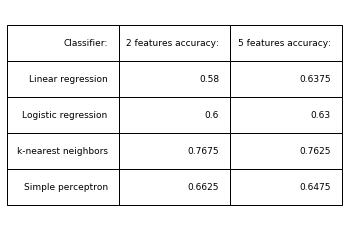

'\nLow number of feature may underfit the model. Adding more features is a great way to prevent underfitting and improve the \nperformance in regression. On the downside it may increase the complexity to much by increasing the search space.\n'

In [61]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
accuracies = [["Classifier:", "2 features accuracy:", "5 features accuracy:"],
             ["Linear regression", accuracy_lin, new_accuracy_lin],
             ["Logistic regression", accuracy_log, new_accuracy_log],
             ["k-nearest neighbors", best_accuracy_knn[1], str(new_best_accuracy_knn)],
             ["Simple perceptron", best_accuracy_per[1], new_best_accuracy_per]]
table = ax.table(cellText=accuracies, loc='center')
table.set_fontsize(16)
table.scale(1,3)
ax.axis('off')
plt.show()

Low number of feature may underfit the model. Adding more features is a great way to prevent underfitting and improve the 
performance in regression. On the downside it may increase the complexity to much by increasing the search space.

# Part II
## Multi-layer neural networks
We will now implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do it in two steps. In the first step, we will work concretely with the dataset (X, t). We will initailize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.

### NOTE
Scaling X_train using function from sklearn.

In [62]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
X_scale = scale.fit_transform(X_train)

## Step1: One round of training

### Intializing
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [63]:
eta = 0.01 #Learning rate
dim_hidden = 6

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *y_train*. Beware that *y_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.

### NOTE
Initializing the dimensions fom input and output. Also modifying the target values.

In [64]:
dim_in =  len(X_train[0])
dim_out = len(set(t_train))

t_train_a = np.zeros((len(X_train[:,0]), dim_out))
t_train_a[t_train == 0] = [1,0,0]
t_train_a[t_train == 1] = [0,1,0]
t_train_a[t_train == 2] = [0,0,1]

We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.

### NOTE
Setting weights and bias so that weights1.shape = (2, 6) and weights2.shape = (6, 3) and the weights is small random numbers between -1 and 1. I chose for this task to have the bias in a separate array to make it easier to analyze. 

In [65]:
weights1 = np.random.uniform(-1,1,size=(dim_in, dim_hidden)) * np.sqrt(1/dim_in)
weights2 = np.random.uniform(-1,1,size=(dim_hidden, dim_out)) * np.sqrt(1/dim_hidden)
bias1 = np.zeros((1, dim_hidden)) *(np.sqrt(1/dim_in))
bias2 = np.zeros((1, dim_out)) *(np.sqrt(1/dim_in))

### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [66]:
#Logistic function from the logistic regression and the derivative logistic function.
def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_deriv(x):
    return x * (1 - x)

### NOTE
Calculating hidden_activation and outout_activation the way it is showed in Marsland p.78 (4.4) to (4,7). The values in the results looks logical.

In [67]:
hidden_activation = logistic((X_train @ weights1) + bias1)

In [68]:
output_activation = logistic((hidden_activation @ weights2) + bias2)

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).

### NOTE
calculating the delta terms also by following the formulas in Marsland p.78 (4.8) to (4,9), and the updating of weights (4.10) to (4,11). The weights are changing.

In [69]:
output_delta = logistic_deriv(output_activation) * (output_activation - t_train_a)

Calculate the error in the hidden layer.

In [70]:
hidden_delta = logistic_deriv(hidden_activation) * ((t_train_a - output_activation) * t_train_a @ weights2.T)

Update the weights.
Check that they have changed.

In [71]:
weights2 -= eta * (hidden_activation.T @ output_delta)
weights1 -= eta * (X_train.T @ hidden_delta)
bias2 -= eta * np.sum(output_delta, axis=0, keepdims=True)
bias1 -= eta * np.sum(hidden_delta, axis=0)

##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

### NOTE
For step 2 i mainly put everything from step 1 i needed to make a classifier. The accuracy method is taken from a earlier classifier. The best accuracy I have gotten so far is 0.70, but it usually ends up around 0.57.

In [193]:
class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.01, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden

        
    def fit(self, X_train, t_train, epochs = 400):
        """Intialize the weights. Train *epochs* many epochs."""
        
        # Initilaization
        (p, X_dim_in) = X_train.shape
        dim_out = len(set(t_train))
        self.x = X_train
        
        #Set weights and bias
        self.weights1 = np.random.uniform(-1,1,size=(X_dim_in, self.dim_hidden)) * np.sqrt(1/dim_in)
        self.weights2 = np.random.uniform(-1,1,size=(self.dim_hidden, dim_out)) * np.sqrt(1/dim_hidden)
        self.bias1 = np.zeros((1, self.dim_hidden)) *(np.sqrt(1/dim_in))
        self.bias2 = np.zeros((1, dim_out)) *(np.sqrt(1/dim_in))
        
        #Scalar to array
        t_train_a = np.zeros((p, dim_out))
        t_train_a[t_train == 0] = [1,0,0]
        t_train_a[t_train == 1] = [0,1,0]
        t_train_a[t_train == 2] = [0,0,1]
        self.t = t_train_a
          
        for e in range(epochs):
            # Run one epoch of forward-backward
            self.forward(self.x)
            self.backward(self.t)

            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        self.hidden_activation = logistic((X @ self.weights1) + self.bias1)
        self.output_activation = logistic((self.hidden_activation @ self.weights2) + self.bias2)
        

    def backward(self, t):
        #Compute deltas
        a1_delta = logistic_deriv(self.hidden_activation) * ((t - self.output_activation) * t @ self.weights2.T)
        a2_delta = ((t - self.output_activation) * logistic_deriv(self.output_activation)) 

        #updating weights and bias
        self.weights2 += self.eta * (self.hidden_activation.T @ a2_delta)
        self.weights1 += self.eta * (self.x.T @ a1_delta)
        self.bias2 += self.eta * np.sum(a2_delta, axis=0, keepdims=True)
        self.bias1 += self.eta * np.sum(a1_delta, axis=0)
        
    
    def accuracy(self, X_test, y_test, **kwargs):
        """Calculate the accuracy of the classifier on the pair (X_test, t_test)
        Return the accuracy"""
        predicted = [self.predict(a, **kwargs) for a in X_test]
        equal = len([(p, g) for (p, g) in zip(predicted, y_test) if p==g])
        return equal / len(y_test)
    
    def predict(self, X_train):
        self.x = X_train
        self.forward(self.x)
        return self.output_activation.argmax()

Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

In [194]:
if __name__ =='__main__':
    MNN = MNNClassifier()
    X_tscale = scale.fit_transform(X_train)
    X_vscale = scale.fit_transform(X_val)
    for _ in range(5):
        MNN.fit(X_tscale, t_train)
        accuracy = MNN.accuracy(X_vscale, t_val)
        print(accuracy)

0.58
0.5775
0.55
0.57
0.695


## For master's students: Early stopping
There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and plot them as in figure 4.11 in Marsland. 

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 

# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

In [146]:
#Confusion matrix method used in week 7.
def cf_matrix(predicted, gold):
    table = np.zeros((2,2))
    for p,g in zip(predicted, gold):
        table[int(p), g] += 1
    print(28*" "+"gold")
    print("{:20}|{:>9}|{:>9}|".format(" ","neg", "pos"))
    print(10*" "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","neg",table[0,0], table[0,1]))
    print("predicted "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ","pos",table[1,0], table[1,1]))
    print(10*" "+30*"-")
    return table



In [174]:
#(X_test, t2_test)
cl = PykNNClassifier(k=14)
cl.fit(X_train.tolist(), t2_train.tolist())

#Confusion matrix
print("KNN confusion matrix:")
predicted = [cl.predict(a) for a in X_test]
table = cf_matrix(predicted, t2_test)

#Accuracy
accuracy = (table[0,0] + table[1,1]) / (table[0,0] + table[0,1] + table[1,0] + table[1,1])
print("KNN accuracy =", accuracy)

#Precision
precision = table[0,0] / (table[0,0] + table[0,1])
print("KNN precision: {:.2f}".format(precision))

#Recall
recall = table[0,0] / (table[0,0] + table[1,0])
print("KNN recall: {:.2f}".format(recall))

KNN confusion matrix:
                            gold
                    |      neg|      pos|
          ------------------------------
          neg       |    141.0|     36.0|
predicted ------------------------------
          pos       |     64.0|    159.0|
          ------------------------------
KNN accuracy = 0.75
KNN precision: 0.80
KNN recall: 0.69


In [192]:
#Confusion matrix method used in week 7 tweaked to 3x3.
def cf_matrix(predicted, gold):
    table = np.zeros((3,3))
    for p,g in zip(predicted, gold):
        table[int(p), g] += 1
    print(28*" "+"gold")
    print("{:20}|{:>9}|{:>9}|".format(" ","", ""))
    print(10*" "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ",table[0,0],table[0,1], table[0,2]))
    print("predicted "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ",table[1,0],table[1,1], table[1,2]))
    print(10*" "+30*"-")
    print("{:10}{:10}|{:9}|{:9}|".format(" ",table[2,0],table[2,1], table[2,2]))
    print(10*" "+30*"-")
    return table

#(X_test, t_test)
MNN = MNNClassifier()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.fit_transform(X_test)
MNN.fit(X_tscale, t_train)

#Accuracy
accuracy = MNN.accuracy(X_test_scale, t_test)
print("MNN accuracy =", str(best_accuracy_knn) + ".")

#Confusion matrix
print("MNN confusion matrix:")
predicted = [MNN.predict(a) for a in X_test]
table = cf_matrix(predicted, t_test)

#Precision
class0_precision = table[0,0] / (table[0,0] + table[0,1] + table[0,2])
class1_precision = table[1,0] / (table[1,0] + table[1,1] + table[1,2])
class2_precision = table[2,0] / (table[2,0] + table[2,1] + table[2,2])

#Recall
class0_recall = table[0,0] / (table[0,0] + table[1,0] + table[2,0])
class1_recall = table[0,1] / (table[0,1] + table[1,1] + table[2,1])
class2_recall = table[0,2] / (table[0,2] + table[1,2] + table[2,2])

print("Class 0\nPrecision:{:.2f}".format(class0_precision))
print("Recall:{:.2f}".format(class0_recall))
print()
print("Class 1\nPrecision:{:.2f}".format(class1_precision))
print("Recall:{:.2f}".format(class1_recall))
print()
print("Class 2\nPrecision:{:.2f}".format(class2_precision))
print("Recall:{:.2f}".format(class2_recall))

"""
Looks like the precision and recall for class 0 is the only one with value. Might be something wrong here..
"""

MNN accuracy = 0.75.
MNN confusion matrix:
                            gold
                    |         |         |
          ------------------------------
                67.0|      7.0|      0.0|
predicted ------------------------------
                25.0|    188.0|    113.0|
          ------------------------------
                 0.0|      0.0|      0.0|
          ------------------------------
Class 0
Precision:0.91
Recall:0.73

Class 1
Precision:0.08
Recall:0.04

Class 2
Precision:nan
Recall:0.00


/Users/kristiangyene/opt/anaconda3/envs/in3050/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


'\nLooks like the precision and recall for class 0 is the only one thats high. Might be something wrong here..\n'

compare accuracies